<a href="https://colab.research.google.com/github/huggingface/huggingface_sb3/blob/main/Stable_Baselines_3_and_Hugging_Face_%F0%9F%A4%97_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines 3 x Hugging Face 🤗 tutorial
Stable-Baselines3 (SB3): https://github.com/DLR-RM/stable-baselines3

Stable-Baselines3 Documentation: https://stable-baselines.readthedocs.io/en/master/

Hugging Face SB3 documentation: https://github.com/huggingface/huggingface_sb3

Hugging Face x SB3 blogpost: https://huggingface.co/blog/sb3

## Introduction
In this notebook, you're going to learn:
1. How to train a Deep Reinforcement Learning lander agent to land correctly on the Moon 🌕 and how upload it to the Hub 🚀.

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2/resolve/main/output.mp4" type="video/mp4"></video>

2. How to download and use a saved model from the Hub that plays Space Invaders 👾.

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-SpaceInvadersNoFrameskip-v4/resolve/main/output.mp4" type="video/mp4"></video>

📚 You can follow this notebook with [the tutorial here]

💡 We advise you to use Google Colab since some environments work only with Ubuntu. The free version of Google Colab is perfect for this tutorial.
Let's get started 🚀

📧 If you have any bugs or feedback and questions, feel free to send me a mail [here](mailto:thomas.simonini@huggingface.co) or DM me (Thomas Simonini) on our [Discord Server](https://t.co/1n75wi976V?amp=1)

### Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `gym[Box2D]`: Contains the LunarLander-v2 environment 🌛
- `gym[Atari]`: Contains the SpaceInvadersNoFrameSkip-v4 environment 👾.
- `stable-baselines3[extra]`: The deep reinforcement learning library.
- `huggingface_sb3`: Additional code for Stable-baselines3 to load and upload models from the Hugging Face 🤗 Hub.
- `huggingface_hub`: Library allowing anyone to work with the Hub repositories.
- `git-lfs`: Git Large File Storage.

In [ ]:
!pip install gym[Box2D]
!pip install gym[Atari]
!pip install stable-baselines3[extra]
!pip install huggingface_sb3
!pip install huggingface_hub

     |████████████████████████████████| 448 kB 8.1 MB/s 
     |████████████████████████████████| 176 kB 7.8 MB/s 
     |████████████████████████████████| 2.8 MB 67.7 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9
     |████████████████████████████████| 67 kB 4.1 MB/s 


In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,681 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# To avoid some bugs we need to have cloudpickle=1.6
!pip install cloudpickle==1.6

  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0


### Step 2: Import the packages 📦

In [ ]:
import gym

from huggingface_sb3 import load_from_hub, push_to_hub

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3.common.env_util import make_vec_env

from huggingface_hub import notebook_login

## Case 1: Train a Deep Reinforcement Learning lander agent to land correctly on the Moon 🌕 and upload it to the Hub.

### Step 3: Create the LunarLander environment 🌛
#### The environment 🎮
In this first tutorial, we’re going to train our agent, a Lunar Lander, **to land correctly on the moon**. To do that, he needs to learn **to adapt its speed and position(horizontal, vertical, and angular) to land correctly.**



In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2/resolve/main/output.mp4" type="video/mp4"></video>

The state is a vector 👁:
- Horizontal pad coordinate (x)
- Vertical pad coordinate (y)
- Horizontal speed (x)
- Vertical speed (y)
- Angle
- Angular speed
- If the left leg has contact point touched the land
- If the right leg has contact point touched the land


The action space is discrete with 4 actions available 🎮: 

- Do nothing,
- Fire left orientation engine,
- Fire the main engine,
- Fire right orientation engine.

Reward function 💰:

- Moving from the top of the screen to the landing pad and zero speed is about 100~140 points.
- Firing main engine is -0.3 each frame
- Each leg ground contact is +10 points
- Episode finishes if the lander crashes (additional - 100 points) or come to rest (+100 points)
- The game is solved if your agent does 200 points.


#### Vectorized Environment
- We create a vectorized environment (method for stacking multiple independent environments into a single environment) of 16 environments, this way, **we'll have more diverse experiences during the training.**

In [ ]:
# Create the environment
env = make_vec_env('LunarLander-v2', n_envs=16)

### Step 4: Create the PPO Model 🤖
PPO is one of the SOTA (state of the art) Deep Reinforcement Learning algorithms. If you don't know how it works, you can check this [blogpost](https://towardsdatascience.com/proximal-policy-optimization-ppo-with-sonic-the-hedgehog-2-and-3-c9c21dbed5e) and the [paper](https://arxiv.org/pdf/1707.06347.pdf)

In this case, because we have a vector as input, we'll use an MLP (multi-layer perceptron) as policy.



In [ ]:
# Define a PPO MLpPolicy architecture
model = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

Using cuda device


### Step 5: Train the PPO agent 🏃
- Let's train our agent for 1,000,000 timesteps, don't forget to use GPU on Colab. It will take approximately ~25min

In [ ]:
# Train it for 1000000 timesteps
model.learn(total_timesteps=1000000)

# Save the model 
model.save("ppo-LunarLander-v2")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 90.5     |
|    ep_rew_mean     | -187     |
| time/              |          |
|    fps             | 4223     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 16384    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.3         |
|    ep_rew_mean          | -151         |
| time/                   |              |
|    fps                  | 2665         |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0059757475 |
|    clip_fraction        | 0.0392       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -3.71e-05    |
|    learning_r

### Step 6: Evaluate the agent 📈
- Now that's our lunar lander agent is trained, we need to **check its performance**.
- Stable-Baselines3 provides a method to do that `evaluate_policy`
- In this case, we see that's the mean reward is `260.16 +/- 18.14` which means that our lunar lander agent is ready to land on the moon 🌛🥳.

In [ ]:
# Evaluate the agent
eval_env = gym.make('LunarLander-v2')
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward=260.16 +/- 18.146285608104712


### Step 7: Let's watch our agent performing 🎥 (Google Colab only)
- We're going to use colabgymrender package by [Ryan Rudes](https://github.com/ryanrudes) that records our agent performing in the environment and outputs a video.

- If you're not using Google Colab, you can check [Stable-baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html?highlight=video#record-a-video)

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2446 sha256=705ef2fcc09be7a773e2ed0aa4408f58f9400dc95188e2b32988a60482ce3cd1
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender


In [ ]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make('LunarLander-v2')
directory = './video'
env = Recorder(env, directory)

obs = env.reset()
done = False
while not done:
  action, _state = model.predict(obs)
  obs, reward, done, info = env.step(action)

env.play()

 97%|█████████▋| 967/1002 [00:02<00:00, 415.87it/s]WARNING:py.warnings:/usr/local/lib/python3.7/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file ./video/1642749174.5047798.mp4, 720000 bytes wanted but 0 bytes read,at frame 1001/1002, at time 33.37/33.37 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 1002/1002 [00:02<00:00, 410.91it/s]


In [ ]:
print(env.path)

./video/1642749174.5047798.mp4


### Step 8: Publish our trained model on the Hub
Now that we saw we got good results after the training, we can now publish our trained model on the hub 🤗. 

This way:
- We can showcase our work.
- We can share with the community a solid agent that others can use.

To be able to share your model with the community there are two more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
notebook_login()
!git config --global credential.helper store

Login successful
Your token has been saved to /root/.huggingface/token


If you don't want to use a Google Colab or a Jupyter Notebook, you need to use another command: `huggingface-cli login`

Then, we need to push this saved model to the 🤗 Hub.
To do that, you need to define 3 things:
- repo_id: the id of the repository `your_username\name_of_the_repo`(this function will create a repository if it does not exist yet, or will update it).
- filename: name of the saved model (in our case ppo-LunarLander-v2 as defined `model.save("ppo-LunarLander-v2")`)
- commit_message: the message of your commit.

=> This push_to_hub function will create a repo if it does not exist yet.

=> If everything works correctly, you'll get the link of the model repo, in our case "https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2"

In [ ]:
# Push this saved model to the hf repo
# If this repo does not exists it will be created
## repo_id =  id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name})
## filename: the name of the file == "name" inside model.save
push_to_hub(repo_id = "ThomasSimonini/ppo-LunarLander-v2",
           filename = "ppo-LunarLander-v2.zip", 
           commit_message = "Added LunarLander-v2 trained model")

REPO NAME:  ppo-LunarLander-v2
ORGANIZATION:  ThomasSimonini


Cloning https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2 into local empty directory.


Download file LunarLander-v2.zip:   1%|1         | 1.58k/140k [00:00<?, ?B/s]

Upload file ppo-LunarLander-v2.zip:   2%|2         | 3.38k/141k [00:00<?, ?B/s]

To https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2
   1ccde6b..8f6d167  main -> main

   1ccde6b..8f6d167  main -> main



'https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2'

Now, if we check https://huggingface.co/ThomasSimonini/ppo-LunarLander-v2, we have our saved model published on the Hub 🥳

### Step 9: Build the Model Card 📝
- To make sure everyone knows what your model can do, its results, etc. We'll update the Model Card to provide useful information.
  - Go to your model

  - Files and versions

  - Click on Readme.md

  - Edit Readme
  - Change with this code (and don't forget to fill the {})
  - In our case:
  - `{name_of_your_repo}`: your_user_name/ppo-LunarLander-v2
  - `{algo}` : PPO
  - `{environment}`: LunarLander-v2
  - `{filename}`: LunarLander-v2
  - `{your_evaluation_results}`: Results of step 6 (mean_reward=243.40 +/- 14.784994887225649)



In [ ]:
#@title
---
tags:
- deep-reinforcement-learning
- reinforcement-learning
- stable-baselines3
---
# {name_of_your_repo}

This is a pre-trained model of a {algo} agent playing {environment} using the [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) library.

### Usage (with Stable-baselines3)
Using this model becomes easy when you have stable-baselines3 and huggingface_sb3 installed:

```
pip install stable-baselines3
pip install huggingface_sb3
```

Then, you can use the model like this:

```python
import gym

from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Retrieve the model from the hub
## repo_id =  id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name})
## filename = name of the model zip file from the repository
checkpoint = load_from_hub(repo_id="{repo_id}", filename="{filename}.zip")
model = PPO.load(checkpoint)

# Evaluate the agent
eval_env = gym.make('{environment}')
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")
 
# Watch the agent play
obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()
env.close()
```

### Evaluation Results
Mean_reward: {your_evaluation_results}



### Optional: Add a video to the model card
💡 The current process will be improved in the next version

- Copy the env.path from step 7
- Replace {env.path} with the copy

In [ ]:
!ffmpeg -i {env.path} -vcodec h264 replay.mp4
# For instance !ffmpeg -i {env.path} -vcodec h264 replay.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

- Then, we push the video to the repository, to be visible with the new video widget, the name of the video **must be replay.mp4**

In [ ]:
# Push the video
## repo_id =  id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name})
## filename: the name of the video file
push_to_hub(repo_id = "ThomasSimonini/ppo-LunarLander-v2",
           filename = "replay.mp4", 
           commit_message = "Added LunarLander-v2 video")

- The video will be displayed on the model card's widget


## Case 2: Download a saved model from the hub that plays Space Invaders 👾
Most of the time, training an agent can be very long (for instance 2 days and more!). To avoid that, you can directly download trained agents on the 🤗 Hub and test them.

Here, we're going to download a trained agent that learned to play Space Invaders 👾



In [ ]:
# We need to add the Atari ROMS (game files) to be able to run the environment.
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-01-21 07:13:50--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   479KB/s    in 24s     

2022-01-21 07:14:14 (462 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
/usr/bin/python3: No module named atari_py.import_roms


### Step 1: Load the saved model from the hub 🤗
Loading a saved model from the Hub is really easy.
1. You go https://huggingface.co/models?other=stable-baselines3 to see the list of all the Stable-baselines3 saved models.
2. You select one and copy its repo_id
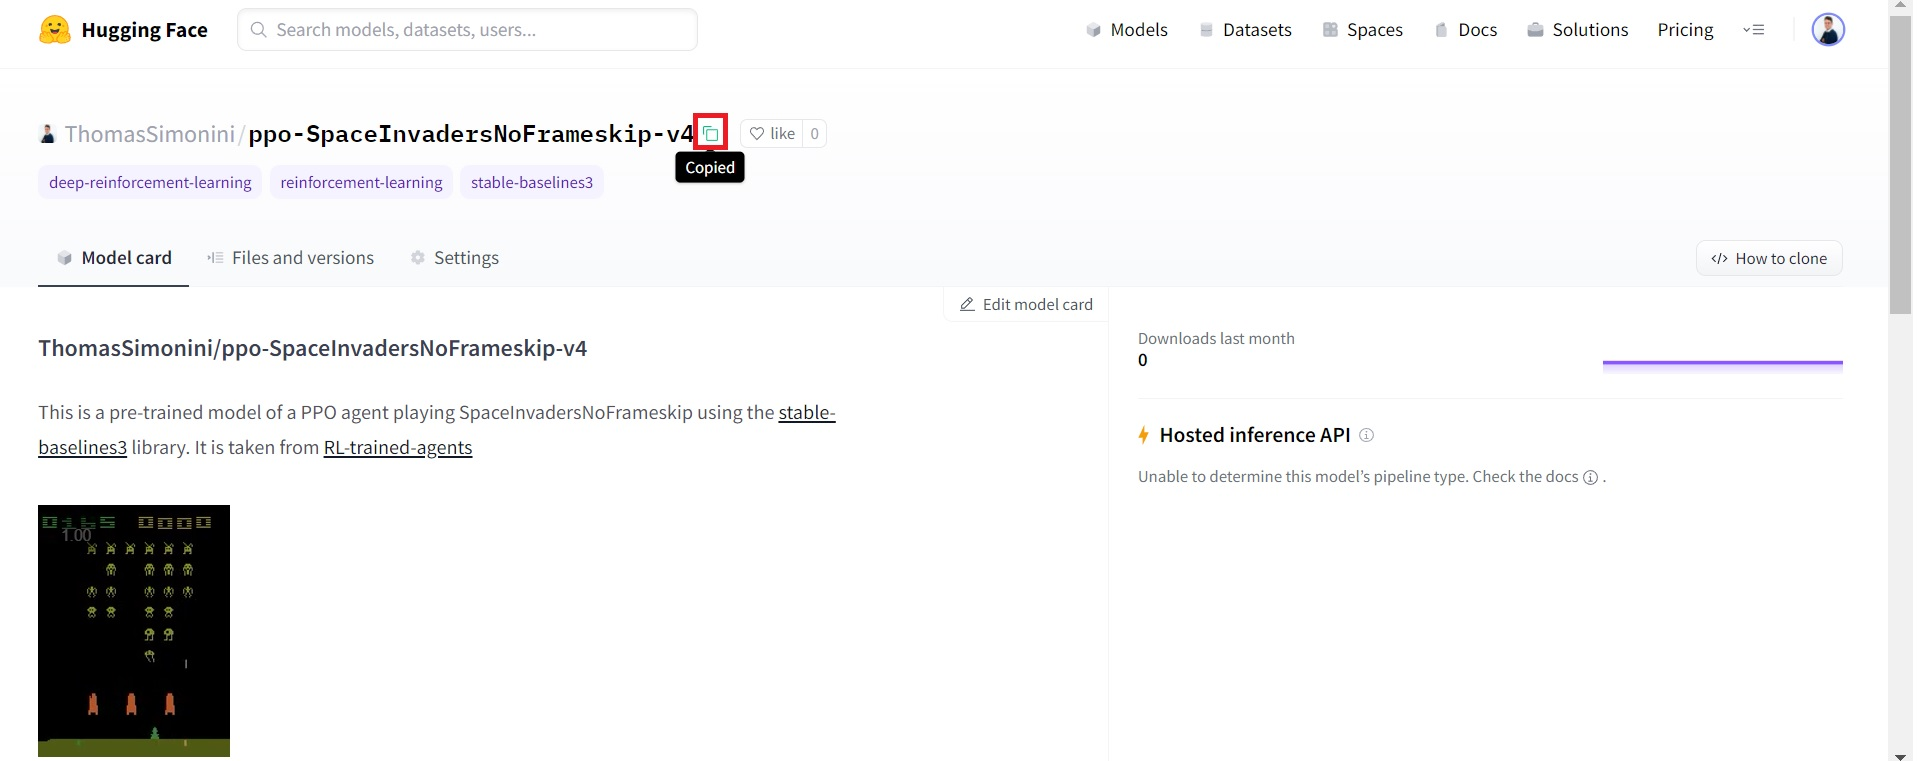
3. Then we just need to use load_from_hub with:
- The repo_id
- The filename: the saved model inside the repo.

In [ ]:
import gym

from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

# Retrieve the model from the hub
## repo_id =  id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name})
## filename = name of the model zip file from the repository
checkpoint = load_from_hub(repo_id="ThomasSimonini/ppo-SpaceInvadersNoFrameskip-v4", filename="ppo-SpaceInvadersNoFrameskip-v4.zip")
print(checkpoint)
model = PPO.load(checkpoint)

Downloading:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

/root/.cache/huggingface/hub/1495e3d265e9b46a2546ddbe0bfc4b72bd3da663568f7742834826304e36c74e.9e7819abff3f9b565dc1eebc527583783fa84ac119435a076ea3bd11bbc14444


### Step 2: Let's watch our agent performing 🎥 (Google Colab only)
- We're going to use colabgymrender package by [Ryan Rudes](https://github.com/ryanrudes) that records our agent performing in the environment and outputs a video.

- If you're not using Google Colab, you can check [Stable-baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html?highlight=video#record-a-video)

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [ ]:
from colabgymrender.recorder import Recorder

env = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)

directory = './video'
env = Recorder(env, directory)

obs = env.reset()
done = False
while not done:
  action, _state = model.predict(obs)
  obs, reward, done, info = env.step(action)
env.play()



100%|█████████▉| 618/619 [00:00<00:00, 1785.80it/s]


That's all for today!

We're excited to see what you're working on with Stable-baselines3 and try your models in the Hub 😍.

And we would love to hear your feedback 💖. 📧 Feel free to [reach us](mailto:thomas.simonini@huggingface.co)  

Finally, we would like to thank the SB3 team and in particular [Antonin Raffin](https://araffin.github.io/) for their precious help for the integration of the library 🤗.

📢 And if you would like to **join our community of creators, we would love to meet you in our Discord server** 🤗.
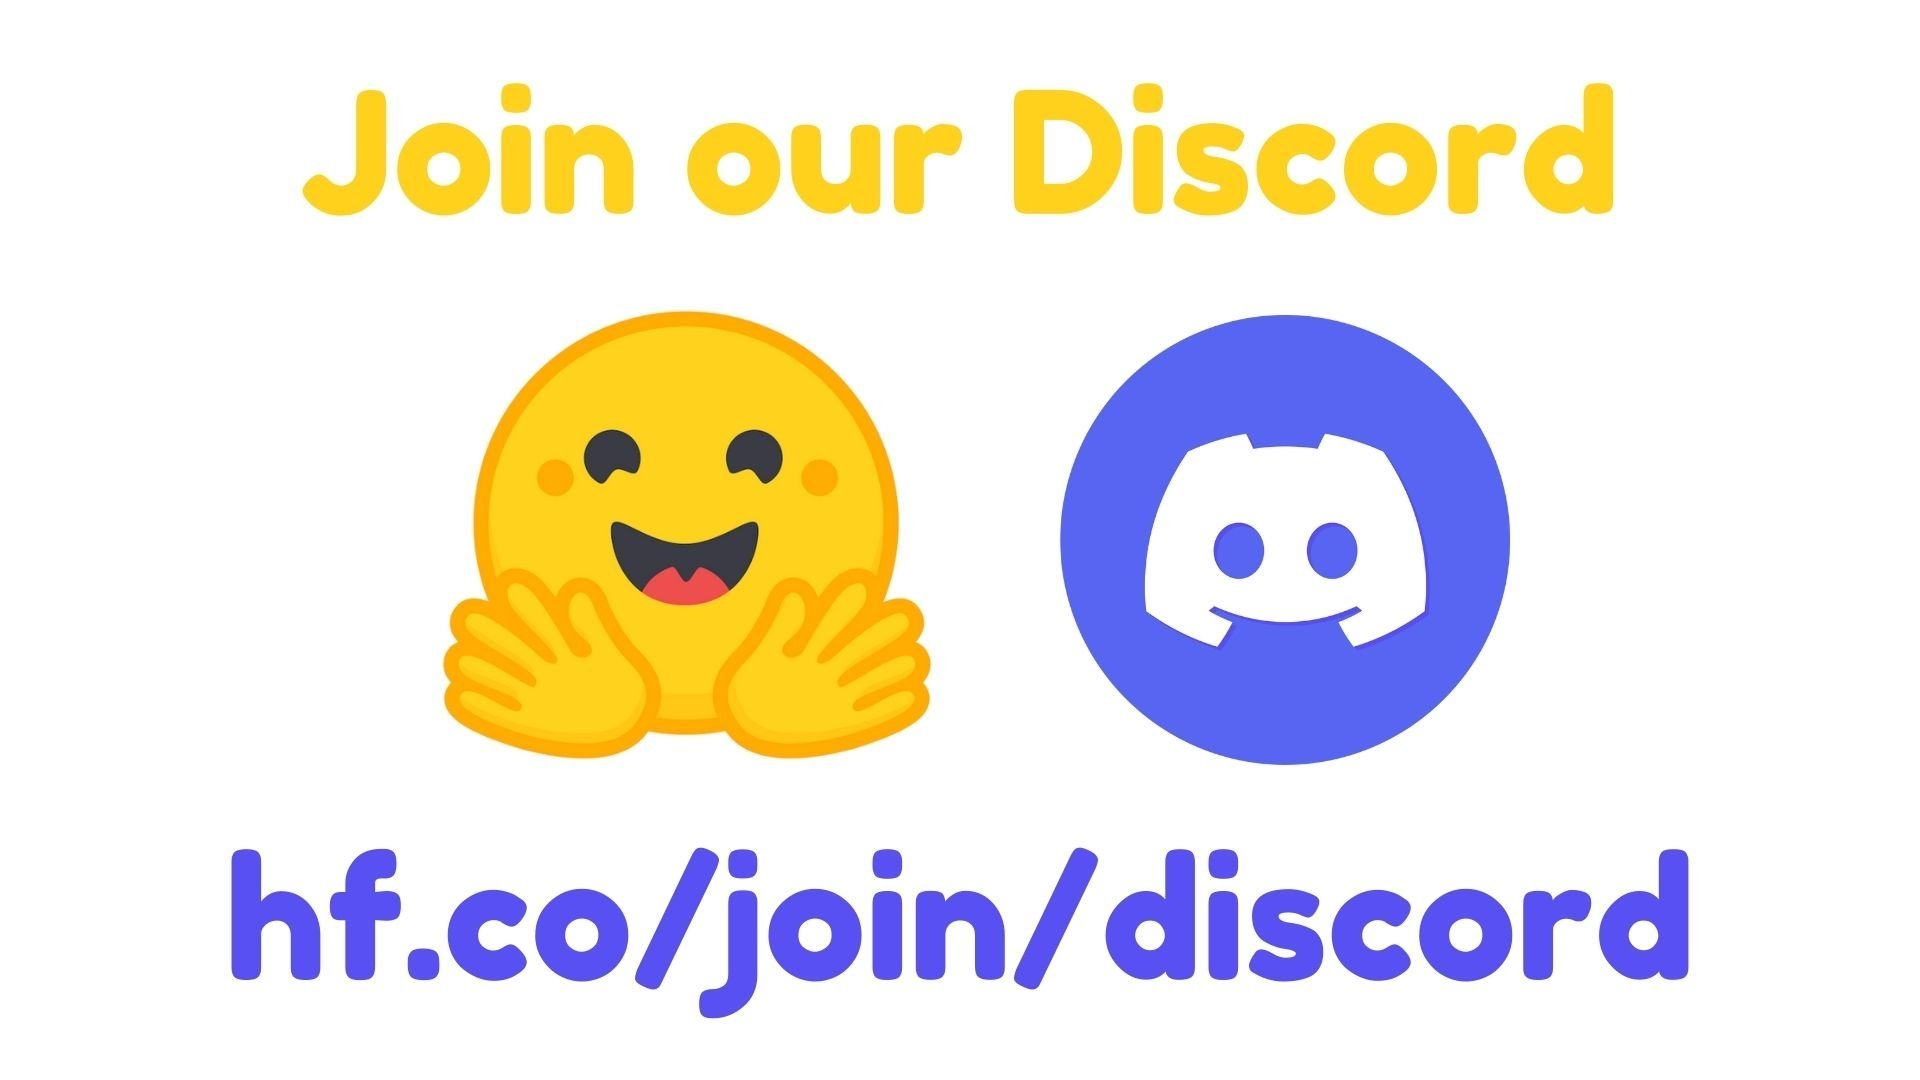
👉 https://discord.gg/Y5HUB4Wrm7